In [1]:
:set -i./src
:load NotebookPrelude

In [2]:
import Data.Set
import System.Random.MWC

type ColdPeerSelection e n = AdjacencyMap e n -> IO (Set n)

-- Take at most a given number of nodes on some path from a given starting node.
stupidColdPeerSelection :: Ord n => Natural -> n -> ColdPeerSelection e n
stupidColdPeerSelection = go Data.Set.empty
  where
  go s 0 n gr = pure s
  go s k n gr = case Data.Set.minView (postSet n gr Data.Set.\\ s) of
    Nothing -> pure s
    Just (m, _) -> go (Data.Set.insert m s) (k-1) m gr
    
randomStupidColdPeerSelection :: Ord n => Natural -> n -> ColdPeerSelection e n
randomStupidColdPeerSelection k n gr = withSystemRandom $ \gen -> go gen Data.Set.empty k n gr
  where
  -- This is used to resolve ambiguity that arises from withSystemRandom.
  pureIO :: s -> IO s
  pureIO = pure
  go gen s 0 n gr = pureIO s
  go gen s k n gr = runRandom (pickN 1 (postSet n gr Data.Set.\\ s)) gen >>= \vs -> case vs of
    [m] -> go gen (Data.Set.insert m s) (k-1) m gr
    _   -> pure s

In [3]:
highlightChosen chosen rgbIn rgbNotIn = filled <> fillColour (\s -> if Data.Set.member (snd s) chosen then rgbIn else rgbNotIn)
highlightChosenHSV chosen hsvIn hsvNotIn = filled <> fillColourHSV (\s -> if Data.Set.member (snd s) chosen then hsvIn else hsvNotIn)

((itt, labels, _), _) <- buildIO $ undirected $ mirror $ do
  vss <- forM [0..8] $ \_ -> freshVertices 8
  cylinder vss (pure ())

((itt, labels, _),_) <- buildIO $ undirected $ mirror $ do
  vss <- freshVertices 128
  cycleOn vss (pure ())

In [4]:
import Ouroboros.Network.PeerSelection.Governor
import Ouroboros.Network.PeerSelection.Test as Test
import Ouroboros.Network.PeerSelection.Types
import Control.Monad.IOSim
import Control.Monad.Class.MonadTime
import qualified Ouroboros.Network.PeerSelection.KnownPeers as KnownPeers
import Data.Typeable (Proxy(..))

With `peerSelectionGovernor` and the IO simulation stuff in scope, it ought to be possible to run the "real thing" and show its progress on a graphviz like we do above for the stupid naive policy. `peerSelectionGovernor` is not factored well into pure, non-concurrent stuff; it's just an `m Void` with a bunch of callbacks. The intention is apparently to use the `IOSim` thing and `runSimTrace` to get a lazy list of trace events, and analyze those. That's to say: define the big hairy mess of concurrency and side-effects up-front, and _then_ try to figure out what's going on by looking at a trace. As opposed to: define the big hairy mess in terms of simple, side-effect- and concurrency-free pieces, and find out what's going on by analyzing these relatively simple pure functional components. /rant

We'll use definitions from `Ouroboros.Network.PeerSelection.Test`. In particular, a `GovernorMockEnvironment` will be needed. The following definitions help us to get one.

In [5]:
import qualified Data.List.NonEmpty as NE
import qualified Data.Set as Set
import qualified Data.Map.Strict as Map

vertexRepToPeerAddr :: VertexRep -> PeerAddr
vertexRepToPeerAddr word32 = PeerAddr (fromIntegral word32)

-- Assumes the PeerAddr is not negative.
peerAddrToVertexRep :: PeerAddr -> VertexRep
peerAddrToVertexRep (PeerAddr int) = fromIntegral int

-- Give all of the vertex's neighbours in unspecified order
mkGossipScript :: AdjacencyMap anyEdgeLabel VertexRep -> VertexRep -> GossipScript
mkGossipScript gr vertex = GossipScript $ pure $ Just
  (fmap vertexRepToPeerAddr neighbours, GossipTimeQuick)
  where
  neighbours = Data.Set.toList (postSet vertex gr)

mkPeerGraph :: AdjacencyMap anyEdgeLabel VertexRep -> PeerGraph
mkPeerGraph gr = PeerGraph $ flip fmap (toAdjacencyList gr) $ \(vertex, neighbours) -> 
  let peerAddr = vertexRepToPeerAddr vertex
      neighbours' = fmap vertexRepToPeerAddr neighbours
      gossipScript = mkGossipScript gr vertex
  in  (gossipScript, peerAddr, neighbours')

Next in the fields of `GovernorMockEnvironment` are `localRootPeers :: Map PeerAddr PeerAdvertise` and `publicRootPeers :: Set PeerAddr`. Judging by the names and types, these are associated with some particular peer, but I don't see why they should be needed in a simulation.

The constructor `TraceGovernorLoopDebug` seems to be the one we need, since it shows the `PeerSelectionState`, from which we can use `Map.keysSet . knownPeersByAddr . knownPeers` to get the set of known peers, and we can create a new graph visualization whenever it changes.

In [6]:
import Data.List.NonEmpty
import Data.Map.Strict
import Test.QuickCheck (NonNegative (..))

selectedPeerSets
  :: PeerSelectionTargets
  -> DiffTime -- Ignore anything that happens after this amount of "time" in hours passes (the governor runs "forever")
  -> AdjacencyMap anyEdgeLabel VertexRep
  -> NonEmpty (Set VertexRep)
selectedPeerSets targets delta gr
  = fmap (Data.Set.map peerAddrToVertexRep)
  . Data.List.NonEmpty.reverse
  . Prelude.foldl collect (pure Data.Set.empty)
  . takeFirstNHours delta
  . selectPeerSelectionTraceEvents Proxy
  . runGovernorInMockEnvironment
  $ env
  
  where
  
  env :: GovernorMockEnvironment
  env = GovernorMockEnvironment
    { peerGraph = mkPeerGraph gr
    , Test.localRootPeers = Map.fromList
        [ (PeerAddr 0,  DoNotAdvertisePeer)
        , (PeerAddr 8, DoNotAdvertisePeer)
        , (PeerAddr 16, DoNotAdvertisePeer)
        , (PeerAddr 24, DoNotAdvertisePeer)
        ]
    , Test.publicRootPeers = Set.empty
    , Test.targets = targets
    , pickKnownPeersForGossip = PickScript (pure (NonNegative 0 :| (fmap NonNegative [1..1024])))
    , pickColdPeersToForget = PickScript (pure (pure (NonNegative 1)))
    }
  
  collect :: NonEmpty (Set PeerAddr) -> (Time, TracePeerSelection PeerAddr) -> NonEmpty (Set PeerAddr)
  collect (s :| ss) (_, TraceGovernorLoopDebug st _) =
    if Data.Map.Strict.keysSet (KnownPeers.toMap (knownPeers st)) == s
    then s :| ss
    else Data.Map.Strict.keysSet (KnownPeers.toMap (knownPeers st)) Data.List.NonEmpty.:| (s : ss)
  collect ss _ = ss

In [7]:
showHighlighted gr set = showTopology (viz Undirected (LayoutFdp False 0.3 1000 Nothing) (nodeShapePoint <> nodeWidth 0.1 <> nodeHeight 0.1 <> highlightChosen set (0,255,0) (0,0,0)) mempty) gr

example = selectedPeerSets (PeerSelectionTargets 2 16 8 4) 1 itt

--fmap (showHighlighted itt) (Prelude.take 5 (Prelude.drop 5 (NE.toList example)))
--fmap (showHighlighted itt) (NE.toList example)

Next idea: instead of making a bunch of different graphs, colour the nodes in a gradient correponding to how long it takes to find them. Darker ==> longer

In [8]:
:set -XBangPatterns

-- For every VertexRep that appears in some set in this list, associate it with the
-- smallest index of a set in which it appears.
rank :: NonEmpty (Set VertexRep) -> Map VertexRep Word
rank = fst . Prelude.foldl collect (Data.Map.Strict.empty, 0)
  where
  collect (!m, !i) s = (Data.Map.Strict.union m (Data.Map.Strict.fromSet (const i) s), i+1)
  
-- Lower ==> more green
-- Higher ==> more dark red
rankColour :: Word -> Word -> (Double, Double, Double)
rankColour max w = (hue, saturation, value)
  where
  hue = interpolate alpha greenHue redHue
  saturation = 1.0
  value = interpolate alpha 1.0 0.2
  alpha = fromIntegral w / fromIntegral max
  -- 120 degrees
  greenHue = 120.0 / 360.0
  -- 0 degrees
  redHue = 0.0 / 360.0
  
interpolate :: Double -> Double -> Double -> Double
interpolate alpha a b = alpha * b + (1.0 - alpha) * a

In [9]:
rank example

fromList [(0,1),(1,2),(2,3),(3,4),(4,5),(5,4),(6,3),(7,2),(8,1),(9,2),(10,6),(11,7),(15,7),(16,1),(17,7),(24,1),(127,2)]

In [10]:
gradient :: NonEmpty (Set VertexRep) -> Double -> Double -> SetAttributes (a, VertexRep)
gradient sets hueEarly hueLate = fillColourHSV $ \(_, v) -> case Data.Map.Strict.lookup v rankMap of
  -- White if never reached (saturation must be 0 to get white)
  Nothing -> (0.0, 0.0, 1.0)
  Just n  -> (hue, saturation, value)
    where
    hue = interpolate alpha hueEarly hueLate
    alpha = fromIntegral n / fromIntegral size
    saturation = 1.0
    value = 1.0
  where
  size = Data.List.NonEmpty.length sets
  rankMap = rank sets
  
showHighlightedGradient gr ranks = showTopology (viz Undirected (LayoutCirco [] 0.1) (nodeShapePoint <> nodeWidth 0.1 <> nodeHeight 0.1 <> filled <> gradient ranks 0.66 0.0) mempty) gr

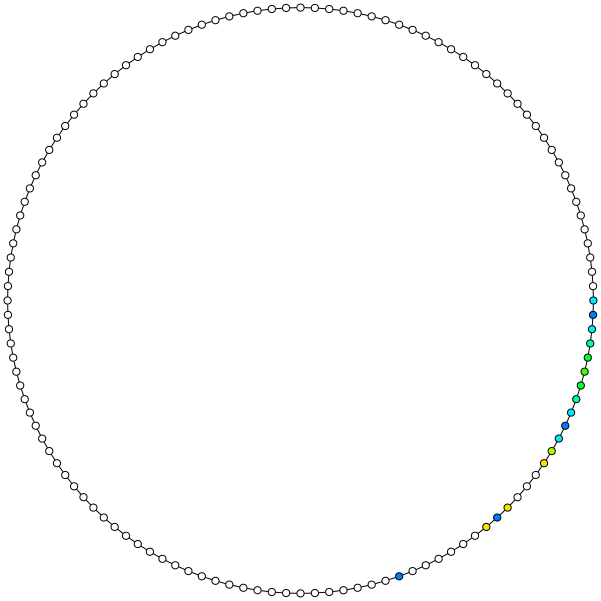

In [11]:
showHighlightedGradient itt example

In [12]:
import Debug.Trace
import Control.Monad.Class.MonadSTM

-- This one is in `m` because we have to set up some mutable cells.
-- A breadth-first policy: new entries to the map (inferred by way of retry and map differences)
-- are enqueued, and the head of the queue is used to generate the next requests.
bfsGossipPolicy :: (MonadSTM m) => m (Map VertexRep KnownPeers.KnownPeerInfo -> Int -> STM m (NonEmpty VertexRep))
bfsGossipPolicy = do
  (queue, candidatesVar) <- atomically ((,) <$> newTQueue <*> newTVar mempty)
  pure (bfsGossip queue candidatesVar)

bfsGossip
  :: (MonadSTM m)
  => TQueue m VertexRep
  -> TVar m (Map VertexRep KnownPeers.KnownPeerInfo)
  -> Map VertexRep KnownPeers.KnownPeerInfo
  -> Int
  -> STM m (NonEmpty VertexRep)
bfsGossip queue candidatesVar newCandidates maxReqs = do
  candidates <- readTVar candidatesVar
  let diff = newCandidates Data.Map.Strict.\\ candidates
      -- We don't care about the peer info, at least not in this iteration.
      shouldContact = Data.Set.toList (Data.Map.Strict.keysSet diff)
  -- To make it DFS, we would use an STM stack instead (TVar [peeraddr])
  forM_ shouldContact (writeTQueue queue)
  -- Important to use tryReadTQueue so that don't never block in case there aren't enough
  -- candidates in the BFS queue.
  toContactMaybe <- forM [1..(maxReqs-1)] (const (tryReadTQueue queue))
  let toContact = NotebookPrelude.mapMaybe id toContactMaybe
  case Data.List.NonEmpty.nonEmpty toContact of
    -- This means that either
    --   maxReqs <= 0, so whatever, we're never going to make progress
    --   shouldContact = [], else the queue would certainly not be empty when we read it
    Nothing -> retry
    Just it -> do
      writeTVar candidatesVar newCandidates
      pure it

In [13]:
:set -XFlexibleContexts -XScopedTypeVariables -XRankNTypes

In [14]:
import Data.List.NonEmpty
import Data.Map.Strict
import Data.Void (Void)

selectedPeerSets
  :: forall s anyEdgeLabel .
     (forall m . MonadSTM m => m (Map VertexRep KnownPeers.KnownPeerInfo -> Int -> STM m (NonEmpty VertexRep)))
     -- ^ Implements gossip: given candidates, choose some to gossip with.
  -> (PeerSelectionState VertexRep -> Set VertexRep)
  -> PeerSelectionTargets
  -> Map VertexRep PeerAdvertise
  -> Set VertexRep
  -> DiffTime -- Ignore anything that happens after this amount of "time" in hours passes (the governor runs "forever")
  -> AdjacencyMap anyEdgeLabel VertexRep
  -> NonEmpty (Set VertexRep)
selectedPeerSets mkGossip mkSet targets localRootPeers publicRootPeers delta gr
  = Data.List.NonEmpty.reverse
  . Prelude.foldl collect (pure Data.Set.empty)
  . takeFirstNHours delta
  . selectPeerSelectionTraceEvents (Proxy :: Proxy VertexRep)
  $ runSimTrace act
  
  where
  
  act :: forall s . SimM s Void
  act = do
    actions <- mkPeerSelectionActions
    policy  <- mkPeerSelectionPolicy
    -- dynamicTracer is from the PeerSelection.Test module
    peerSelectionGovernor dynamicTracer actions policy
  
  -- Copied mostly from mockPeerSelectionActions in Test module.
  mkPeerSelectionActions :: forall s . SimM s (PeerSelectionActions VertexRep (SimM s))
  mkPeerSelectionActions = do
    pure PeerSelectionActions
      { readPeerSelectionTargets = pure targets
      , readLocalRootPeers = pure localRootPeers
      , requestPublicRootPeers = \_ -> pure (publicRootPeers, 0)
      , requestPeerGossip = \addr ->
          let adjs = postSet addr gr
          in  pure (Set.toList adjs)
      }
  
  -- Copied mostly from the mockPeerSelectionPolicy in Test module.
  mkPeerSelectionPolicy :: forall s . SimM s (PeerSelectionPolicy VertexRep (SimM s))
  mkPeerSelectionPolicy = do
    gossip <- mkGossip
    pure PeerSelectionPolicy
      { policyPickKnownPeersForGossip = gossip
      , policyPickColdPeersToForget = \m _ -> case Map.toList m of
          []       -> retry
          (addr:_) -> pure (pure (fst addr))
      , policyFindPublicRootTimeout = 5
      , policyMaxInProgressGossipReqs = 2
      , policyGossipRetryTime = 3600
      , policyGossipBatchWaitTime = 3
      , policyGossipOverallTimeout = 10
      }
  
  collect :: NonEmpty (Set VertexRep) -> (Time, TracePeerSelection VertexRep) -> NonEmpty (Set VertexRep)
  collect (s :| ss) (_, TraceGovernorLoopDebug st _) =
    if mkSet st == s
    then s :| ss
    else mkSet st Data.List.NonEmpty.:| (s : ss)
  collect ss _ = ss

allKnownPeers :: PeerSelectionState VertexRep -> Set VertexRep
allKnownPeers = Data.Map.Strict.keysSet . KnownPeers.toMap . knownPeers

onlyHotPeers :: PeerSelectionState VertexRep -> Set VertexRep
onlyHotPeers = Data.Map.Strict.keysSet . activePeers

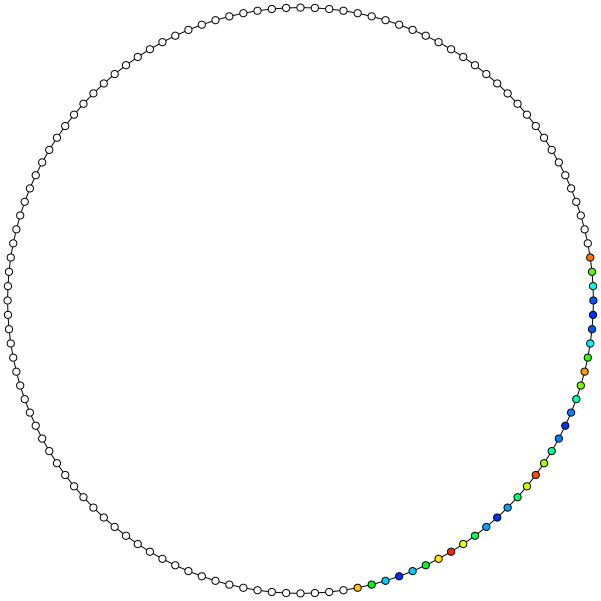

In [15]:
example = selectedPeerSets bfsGossipPolicy allKnownPeers (PeerSelectionTargets 4 32 8 4) (Map.fromList [(0, DoNotAdvertisePeer), (8, DoNotAdvertisePeer), (16, DoNotAdvertisePeer), (24, DoNotAdvertisePeer)]) (Set.singleton 0) 1 itt
showHighlightedGradient itt example

In [16]:
import System.Random

searchGossip
  :: (MonadSTM m)
  => (VertexRep -> STM m ())
  -> STM m (Maybe VertexRep)
  -> TVar m (Map VertexRep KnownPeers.KnownPeerInfo)
  -> Map VertexRep KnownPeers.KnownPeerInfo
  -> Int
  -> STM m (NonEmpty VertexRep)
searchGossip insert remove candidatesVar newCandidates maxReqs = do
  candidates <- readTVar candidatesVar
  let diff = newCandidates Data.Map.Strict.\\ candidates
      -- We don't care about the peer info, at least not in this iteration.
      shouldContact = Data.Set.toList (Data.Map.Strict.keysSet diff)
  -- To make it DFS, we would use an STM stack instead (TVar [peeraddr])
  forM_ shouldContact insert
  -- Important to use tryReadTQueue so that don't never block in case there aren't enough
  -- candidates in the BFS queue.
  toContactMaybe <- forM [1..(maxReqs-1)] (const remove)
  let toContact = NotebookPrelude.mapMaybe id toContactMaybe
  case Data.List.NonEmpty.nonEmpty toContact of
    -- This means that either
    --   maxReqs <= 0, so whatever, we're never going to make progress
    --   shouldContact = [], else the queue would certainly not be empty when we read it
    Nothing -> retry
    Just it -> do
      writeTVar candidatesVar newCandidates
      pure it
      
bfsGossip :: (MonadSTM m) => m (Map VertexRep KnownPeers.KnownPeerInfo -> Int -> STM m (NonEmpty VertexRep))
bfsGossip = do
  (queue, candidatesVar) <- atomically ((,) <$> newTQueue <*> newTVar mempty)
  let insert = writeTQueue queue
      remove = tryReadTQueue queue
  pure (searchGossip insert remove candidatesVar)

listHead :: [a] -> (Maybe a, [a])
listHead ls = case ls of { [] -> (Nothing, []); (a:as) -> (Just a, as) }

dfsGossip :: (MonadSTM m) => m (Map VertexRep KnownPeers.KnownPeerInfo -> Int -> STM m (NonEmpty VertexRep))
dfsGossip = do
  (stack, candidatesVar) <- atomically ((,) <$> newTVar [] <*> newTVar mempty)
  let insert = \a -> modifyTVar stack ((:) a)
      remove = do
        xs <- readTVar stack
        let (mHead, xs') = listHead xs
        writeTVar stack xs'
        pure mHead
  pure (searchGossip insert remove candidatesVar)

-- Randomly select from the pool of candidates.
--
-- Unfortunately we can't re-use the definitions from the graph builder
-- module, because they use mwc-random, which requires ST or IO, which can't
-- be run within an STM transaction (complicated even more still by the fact
-- that we are using the io-sim-classes). It _could_ in theory be put into
-- the transaction, because the transaction never reties (and the effects are
-- benign anyway). But then we would need an unsafePerformIO variant for SimM...
-- or could just use unsafePerformIO directly...
selectRandom :: StdGen -> [x] -> (Maybe (x, [x]), StdGen)
selectRandom prng list = case list of
  [] -> (Nothing, prng)
  _  -> (Just (x, prefix ++ suffix), prng')
  where
  (idx, prng') = randomR (0, Prelude.length list - 1) prng
  (prefix, x : suffix) = Prelude.splitAt idx list

randomGossip :: (MonadSTM m) => StdGen -> m (Map VertexRep KnownPeers.KnownPeerInfo -> Int -> STM m (NonEmpty VertexRep))
randomGossip prng = do
  (poolVar, prngVar, candidatesVar) <- atomically ((,,) <$> newTVar [] <*> newTVar prng <*> newTVar mempty)
  let insert = \a -> modifyTVar poolVar ((:) a)
      remove = do
        xs   <- readTVar poolVar
        prng <- readTVar prngVar
        let (selection, prng') = selectRandom prng xs
        writeTVar prngVar prng'
        case selection of
          Nothing       -> pure Nothing
          Just (x, xs') -> writeTVar poolVar xs' >> pure (Just x)
  pure (searchGossip insert remove candidatesVar)

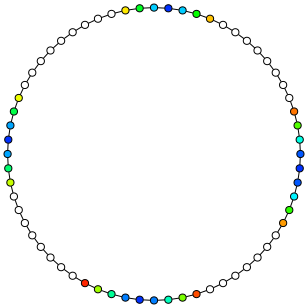

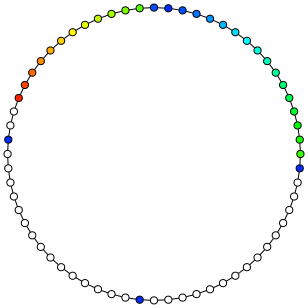

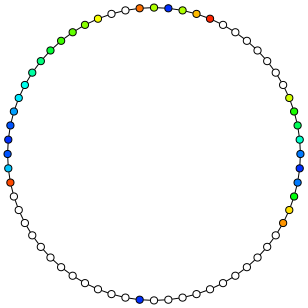

In [17]:
((itt, labels, _), _) <- buildIO $ undirected $ mirror $ do
  vs <- freshVertices 64
  cycleOn vs (pure ())
gen <- newStdGen
example = selectedPeerSets bfsGossip allKnownPeers (PeerSelectionTargets 4 32 8 4) (Map.fromList [(0, DoNotAdvertisePeer), (16, DoNotAdvertisePeer), (32, DoNotAdvertisePeer), (48, DoNotAdvertisePeer)]) (Set.singleton 0) 1 itt
showHighlightedGradient itt example
example = selectedPeerSets dfsGossip allKnownPeers (PeerSelectionTargets 4 32 8 4) (Map.fromList [(0, DoNotAdvertisePeer), (16, DoNotAdvertisePeer), (32, DoNotAdvertisePeer), (48, DoNotAdvertisePeer)]) (Set.singleton 0) 1 itt
showHighlightedGradient itt example
example = selectedPeerSets (randomGossip gen) allKnownPeers (PeerSelectionTargets 4 32 8 4) (Map.fromList [(0, DoNotAdvertisePeer), (16, DoNotAdvertisePeer), (32, DoNotAdvertisePeer), (48, DoNotAdvertisePeer)]) (Set.singleton 0) 1 itt
showHighlightedGradient itt example

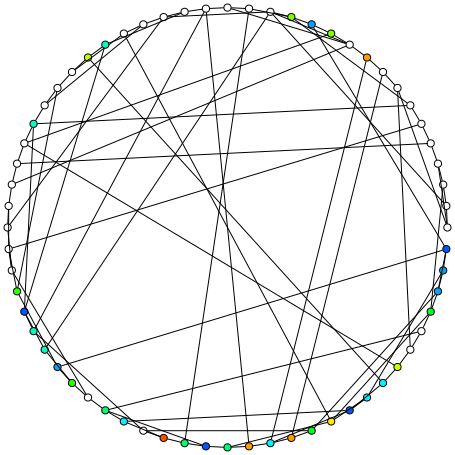

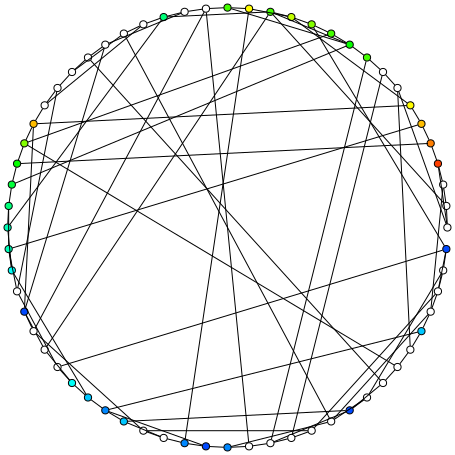

In [27]:
showHighlightedGradient gr ranks = showTopology (viz Undirected (LayoutCirco [] 0.2) (nodeShapePoint <> nodeWidth 0.1 <> nodeHeight 0.1 <> filled <> gradient ranks 0.66 0.0) mempty) gr

((itt, labels, _), _) <- buildIO $ undirected $ mirror $ do
  vs <- freshVertices 64
  kregular vs (pure 3) (pure ())
exampleBfs = selectedPeerSets bfsGossip allKnownPeers (PeerSelectionTargets 4 32 8 4) (Map.fromList [(0, DoNotAdvertisePeer), (8, DoNotAdvertisePeer), (16, DoNotAdvertisePeer), (24, DoNotAdvertisePeer)]) (Set.singleton 0) 1 itt
exampleDfs = selectedPeerSets dfsGossip allKnownPeers (PeerSelectionTargets 4 32 8 4) (Map.fromList [(0, DoNotAdvertisePeer), (8, DoNotAdvertisePeer), (16, DoNotAdvertisePeer), (24, DoNotAdvertisePeer)]) (Set.singleton 0) 1 itt
showHighlightedGradient itt exampleBfs
showHighlightedGradient itt exampleDfs

Next, we can generate families of graphs parameterized on their size, and run peer selection on them using BFS, DFS, and random selection. What statistic to compute? Add a new vertex corresponding to the hypothetical peer that is doing the peer selection, put edges from it to each of its hot peers, and calculate the shortest paths from that vertex, then take the 95th percentile of this data set (weights are hops).

To do this, we'll need something more than `selectedPeerSets` as it's defined at the moment. It must also give the
"hot" peers.

In [61]:
import qualified Algebra.Graph.Labelled.AdjacencyMap as Graph
import Graphics.Rendering.Chart.Backend.Cairo

mkDataSet :: Natural -> Natural -> Natural -> (Natural -> PeerSelectionTargets) -> (Natural -> [VertexRep]) -> IO [(Natural, ([Double], [Double], [Double]))]
mkDataSet from to n targets roots = forM [from..to] $ \n -> do
  -- v is the vertex from which we'll compute shortest paths later on.
  -- It's `freshVertex` so we're sure it has no edges in or out.
  ((itt,_,v),_) <- buildIO $ undirected $ mirror $ do
    vs <- freshVertices n
    kregular vs (pure 3) (pure ())
    fmap getVertexRep freshVertex
  gen <- newStdGen
  let roots' = Map.fromList (fmap (flip (,) DoNotAdvertisePeer) (roots n))
      targets' = targets n
      -- The sets of hot peers for breadth, depth, and random policies.
      -- FIXME actually using all known peers for the moment. Change to include hot peers only.
      bfs = selectedPeerSets bfsGossip          allKnownPeers targets' roots' (Set.singleton 0) 1 itt
      dfs = selectedPeerSets dfsGossip          allKnownPeers targets' roots' (Set.singleton 0) 1 itt
      rnd = selectedPeerSets (randomGossip gen) allKnownPeers targets' roots' (Set.singleton 0) 1 itt
      -- For each of these we take the final set of hot peers and then compute the shortest paths from
      -- the vertex with edges to these hot peers.
      graph ds = Prelude.foldl (\g w -> Graph.overlay g (Graph.edge (Last ()) v w)) itt (Set.toList (Data.List.NonEmpty.last ds))
      bfsGraph = graph bfs
      dfsGraph = graph dfs
      rndGraph = graph rnd
      mkWeight = \_ _ -> hop
      bfsSps = dijkstra mkWeight v bfsGraph
      dfsSps = dijkstra mkWeight v dfsGraph
      rndSps = dijkstra mkWeight v rndGraph
      bfsData = Map.elems (fmap (fromIntegral . path_length) bfsSps)
      dfsData = Map.elems (fmap (fromIntegral . path_length) dfsSps)
      rndData = Map.elems (fmap (fromIntegral . path_length) rndSps)
  pure (n, (bfsData, dfsData, rndData))
  
dataSet <- mkDataSet 128 256 3 (\n -> PeerSelectionTargets 4 32 0 0) (\n -> [0,1,2,3])
  
renderableToFile (FileOptions (1024,576) PNG) "chart.png" $ chart_numeric_xy $ do
  layout_title .= "Peer selection in 3-regular random graph"
  layout_x_axis . laxis_title .= "Size of graph"
  layout_y_axis . laxis_title .= "Maximum distance from known peer"
  showPlot' $ do
    plot_points_title  .= "Breadth first"
    plot_points_style  .= mk (do
        point_radius .= 2.0
        point_color  .= opaque red
      )
    plot_points_values .= fmap (\(n, (ds,_,_)) -> (fromIntegral n, percentile 100 ds)) dataSet
  showPlot' $ do
    plot_points_title  .= "Depth first"
    plot_points_style  .= mk (do
        point_radius .= 2.0
        point_color  .= opaque blue
      )
    plot_points_values .= fmap (\(n, (_,ds,_)) -> (fromIntegral n, percentile 100 ds)) dataSet
  showPlot' $ do
    plot_points_title  .= "Random"
    plot_points_style  .= mk (do
        point_radius .= 2.0
        point_color  .= opaque green
      )
    plot_points_values .= fmap (\(n, (_,_,ds)) -> (fromIntegral n, percentile 100 ds)) dataSet



Line 1: Use const
Found:
\ n -> [0, 1, 2, 3]
Why not:
const [0, 1, 2, 3]